In [ ]:
# Step A1: Install and import necessary libraries
!pip install pandas matplotlib seaborn plotly scikit-learn --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [ ]:
# Step B1: Load datasets
customers = pd.read_csv('/content/customers_dataset.csv')
geolocation = pd.read_csv('/content/geolocation_dataset.csv')
order_items = pd.read_csv('/content/order_items_dataset.csv')
order_payments = pd.read_csv('/content/order_payments_dataset.csv')
order_reviews = pd.read_csv('/content/order_reviews_dataset.csv')
orders = pd.read_csv('/content/orders_dataset.csv')
products = pd.read_csv('/content/products_dataset.csv')
sellers = pd.read_csv('/content/sellers_dataset.csv')
category_translation = pd.read_csv('/content/product_category_name_translation.csv')


In [ ]:
# Step C1: Quick overview of all datasets
dfs = [customers, geolocation, order_items, order_payments, order_reviews, orders, products, sellers, category_translation]
names = ['customers', 'geolocation', 'order_items', 'order_payments', 'order_reviews', 'orders', 'products', 'sellers', 'category_translation']

for df, name in zip(dfs, names):
    print(f"--- {name.upper()} ---")
    print(df.shape)
    print(df.info())
    print(df.head(2), '\n')


--- CUSTOMERS ---
(99441, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
None
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP   

--- 

In [ ]:
# Step D1: Convert date columns in `orders`
date_cols = [col for col in orders.columns if 'date' in col]
for col in date_cols:
    orders[col] = pd.to_datetime(orders[col], errors='coerce')

# Step D2: Translate product categories
products = products.merge(category_translation, on='product_category_name', how='left')


In [ ]:
# Step E1: Merge datasets for a unified view
order_df = orders.merge(customers, on='customer_id', how='left') \
                 .merge(order_payments, on='order_id', how='left') \
                 .merge(order_items, on='order_id', how='left') \
                 .merge(order_reviews, on='order_id', how='left') \
                 .merge(products, on='product_id', how='left') \
                 .merge(sellers, on='seller_id', how='left')


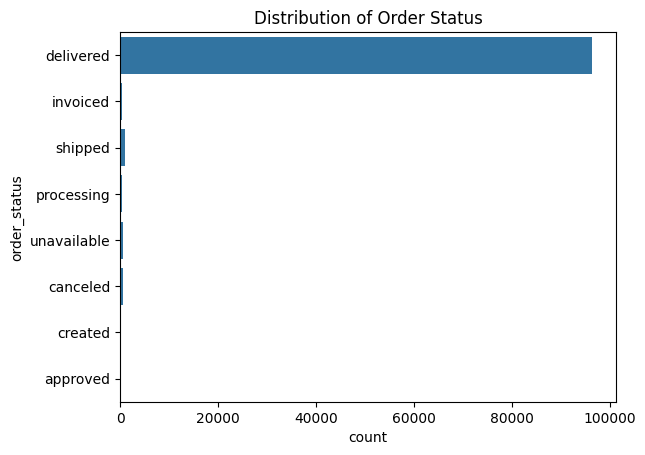

In [ ]:
sns.countplot(y='order_status', data=orders)
plt.title('Distribution of Order Status')
plt.show()


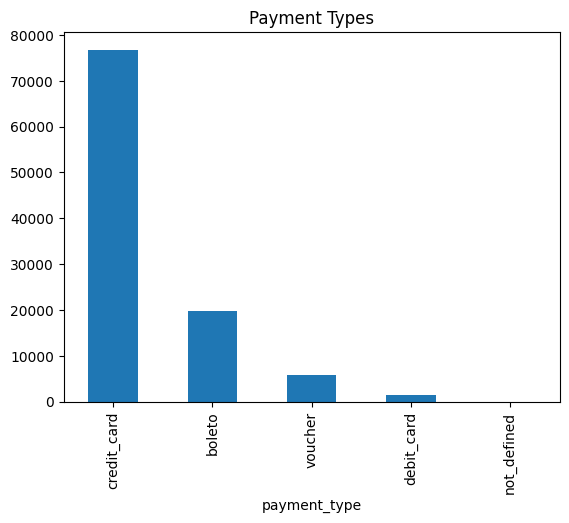

In [ ]:
order_payments['payment_type'].value_counts().plot(kind='bar', title='Payment Types')
plt.show()


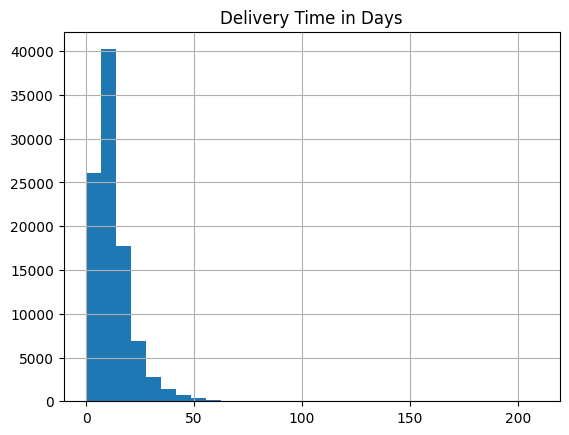

In [ ]:
orders['delivery_time'] = (pd.to_datetime(orders['order_delivered_customer_date'], errors='coerce') - pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')).dt.days
orders['delivery_time'].dropna().hist(bins=30)
plt.title('Delivery Time in Days')
plt.show()


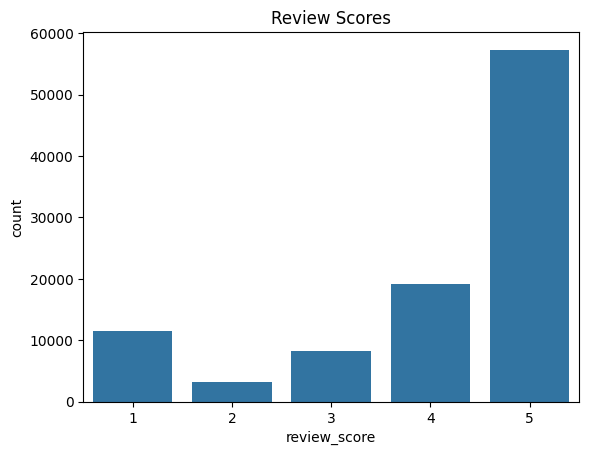

In [ ]:
sns.countplot(x='review_score', data=order_reviews)
plt.title('Review Scores')
plt.show()


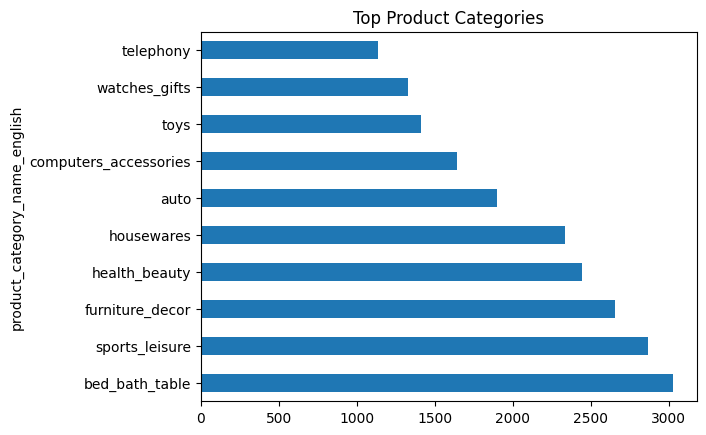

In [ ]:
top_categories = products['product_category_name_english'].value_counts().head(10)
top_categories.plot(kind='barh', title='Top Product Categories')
plt.show()


# BUSINESS INSIGHTS
Here are some High value insights where an E-Commerce company must look into for their growth


1. Which product categories have the most returns or bad reviews?

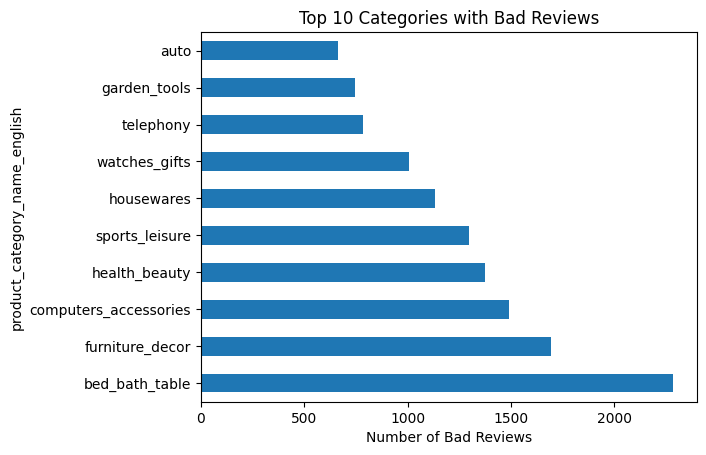

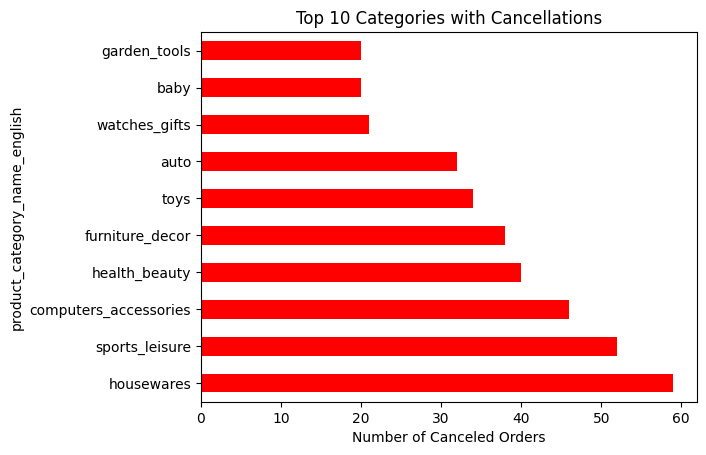

In [ ]:
# 1A. Bad reviews by product category
bad_reviews = order_df[order_df['review_score'] <= 2]
bad_review_counts = bad_reviews['product_category_name_english'].value_counts().head(10)

bad_review_counts.plot(kind='barh', title='Top 10 Categories with Bad Reviews')
plt.xlabel('Number of Bad Reviews')
plt.show()

# 1B. Returns by product category
canceled_orders = order_df[order_df['order_status'] == 'canceled']
canceled_counts = canceled_orders['product_category_name_english'].value_counts().head(10)

canceled_counts.plot(kind='barh', color='red', title='Top 10 Categories with Cancellations')
plt.xlabel('Number of Canceled Orders')
plt.show()

 2. Are there sellers or regions that frequently cause delays?

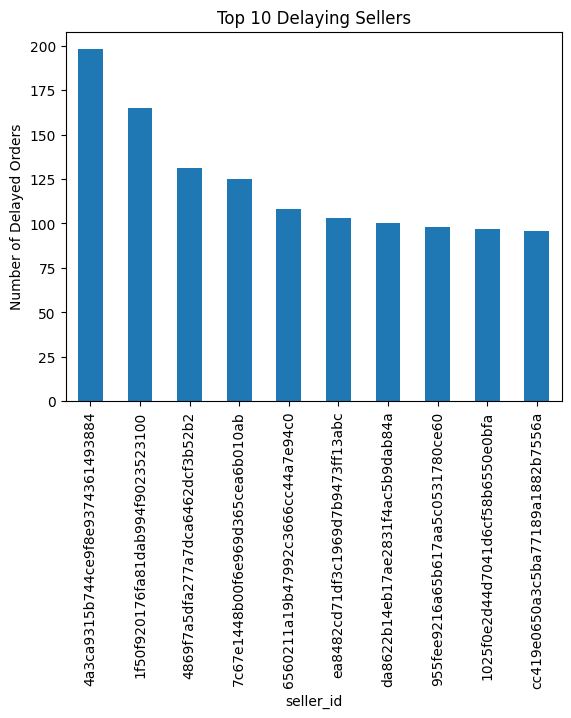

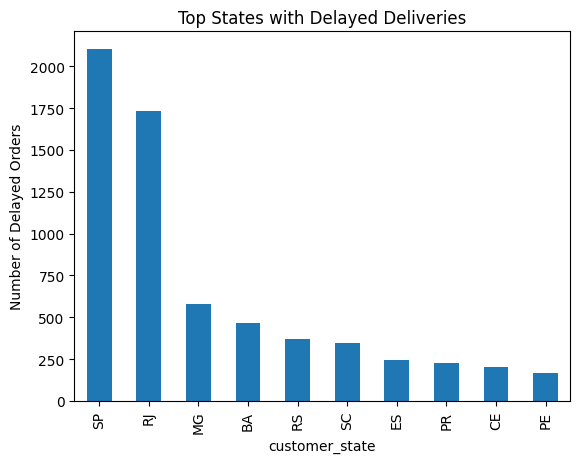

In [ ]:
# Convert to datetime
order_df['shipping_delay'] = (
    order_df['order_delivered_customer_date'] - order_df['order_estimated_delivery_date']
).dt.days

# Delay > 0
delays = order_df[order_df['shipping_delay'] > 0]

# 2A. Sellers with most delays
seller_delay_counts = delays['seller_id'].value_counts().head(10)
seller_delay_counts.plot(kind='bar', title='Top 10 Delaying Sellers')
plt.ylabel('Number of Delayed Orders')
plt.show()

# 2B. Regions with most delays (based on customer state)
delays_by_state = delays['customer_state'].value_counts().head(10)
delays_by_state.plot(kind='bar', title='Top States with Delayed Deliveries')
plt.ylabel('Number of Delayed Orders')
plt.show()


 3. What's the average ticket size per customer/region/product category?

Average ticket size per customer: R$148.54


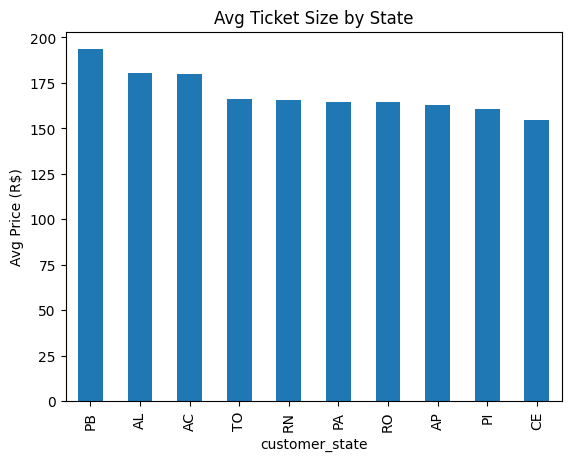

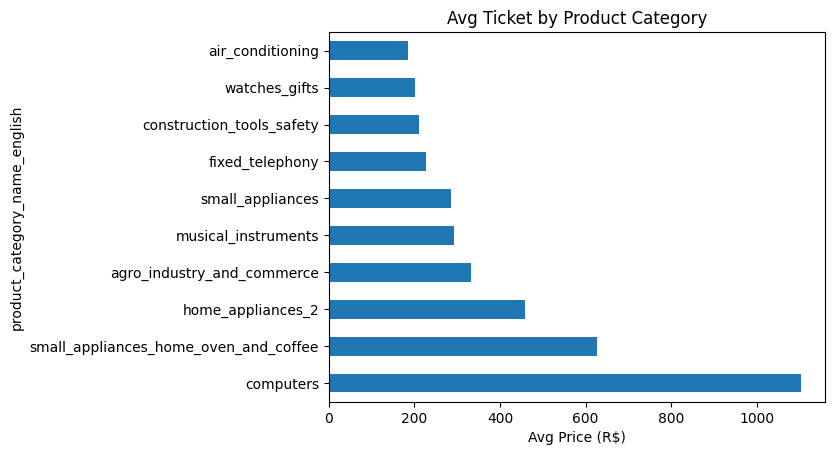

In [ ]:
# 3A. Avg order value per customer
avg_ticket_per_customer = order_df.groupby('customer_unique_id')['price'].sum().mean()
print(f"Average ticket size per customer: R${avg_ticket_per_customer:.2f}")

# 3B. Avg ticket size by state
avg_ticket_state = order_df.groupby('customer_state')['price'].mean().sort_values(ascending=False).head(10)
avg_ticket_state.plot(kind='bar', title='Avg Ticket Size by State')
plt.ylabel('Avg Price (R$)')
plt.show()

# 3C. Avg ticket by category
avg_ticket_category = order_df.groupby('product_category_name_english')['price'].mean().sort_values(ascending=False).head(10)
avg_ticket_category.plot(kind='barh', title='Avg Ticket by Product Category')
plt.xlabel('Avg Price (R$)')
plt.show()


 4. Do certain payment types correlate with higher order values or faster fulfillment?

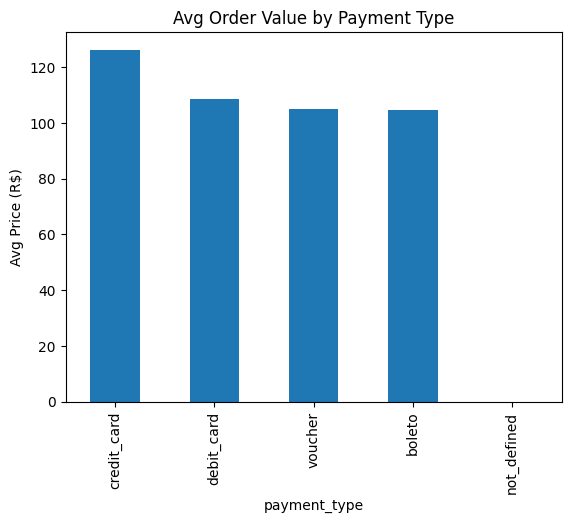

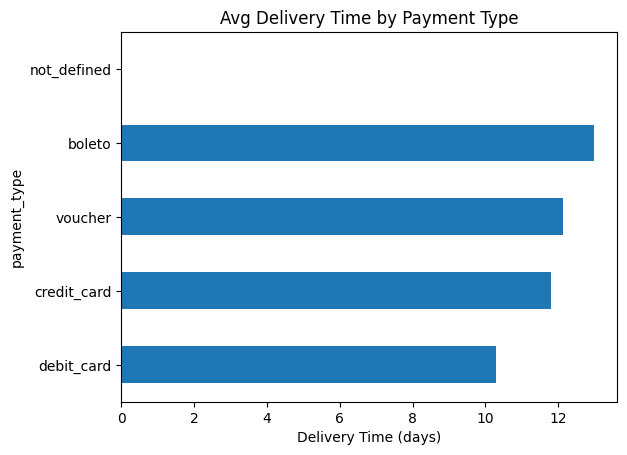

In [ ]:
# 4A. Avg order value by payment type
avg_payment_value = order_df.groupby('payment_type')['price'].mean().sort_values(ascending=False)
avg_payment_value.plot(kind='bar', title='Avg Order Value by Payment Type')
plt.ylabel('Avg Price (R$)')
plt.show()

# 4B. Avg delivery time by payment type
# Ensure datetime format
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'], errors='coerce')
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'], errors='coerce')

# Calculate delivery time, handling NaT values
order_df['delivery_time'] = (order_df['order_delivered_customer_date'] - order_df['order_purchase_timestamp']).dt.days

avg_delivery_by_payment = order_df.groupby('payment_type')['delivery_time'].mean().sort_values()
avg_delivery_by_payment.plot(kind='barh', title='Avg Delivery Time by Payment Type')
plt.xlabel('Delivery Time (days)')
plt.show()


 5. How does delivery time affect review scores?

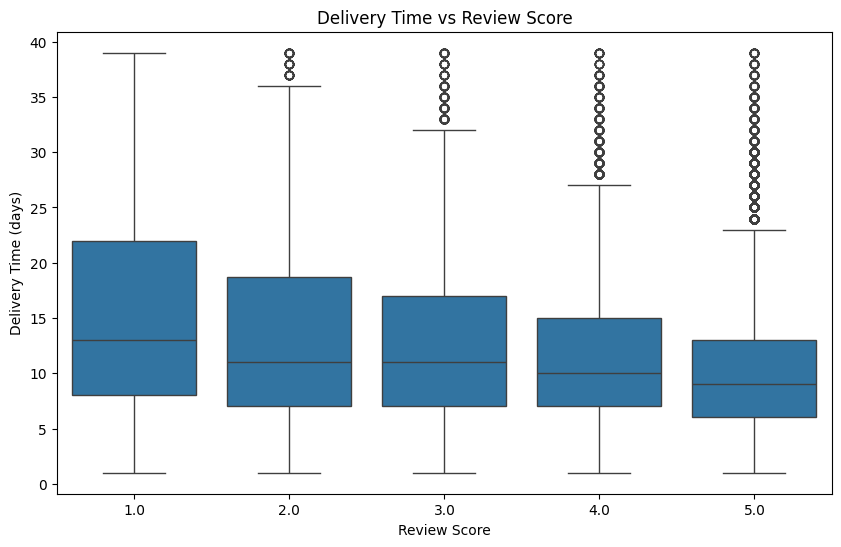

In [ ]:
# Remove outliers (extreme delivery times)
df_filtered = order_df[(order_df['delivery_time'] > 0) & (order_df['delivery_time'] < 40)]

plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='delivery_time', data=df_filtered)
plt.title('Delivery Time vs Review Score')
plt.xlabel('Review Score')
plt.ylabel('Delivery Time (days)')
plt.show()


6. Classification Model to Predict Late Deliveries

In [ ]:
# Prepare data
order_df['late_delivery'] = (order_df['shipping_delay'] > 0).astype(int)
features = ['price', 'freight_value', 'payment_value', 'delivery_time']
X = order_df.dropna(subset=features + ['late_delivery'])[features]
y = order_df.dropna(subset=features + ['late_delivery'])['late_delivery']

# Train/test split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     21650
           1       0.79      0.71      0.75      1494

    accuracy                           0.97     23144
   macro avg       0.89      0.85      0.87     23144
weighted avg       0.97      0.97      0.97     23144



7. Customer Segmentation with RFM Analysis (Clustering)

RECENCY - FREQUENCY - MONETARY

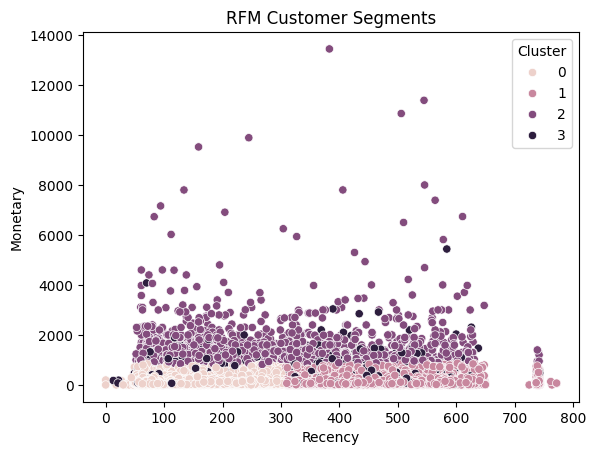

In [ ]:
# RFM Features
latest = order_df['order_purchase_timestamp'].max()
rfm = order_df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (latest - x.max()).days,
    'order_id': 'count',
    'price': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Visualize clusters
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Cluster')
plt.title('RFM Customer Segments')
plt.show()


9. Map Delivery Delays by State (Geolocation + Folium)

In [ ]:
!pip install folium
!pip install geopy

import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable # Import GeocoderUnavailable
import pandas as pd # Import pandas
import time # Import the time module

# Assuming you have the necessary DataFrames loaded, e.g., orders, customers, etc.
# ... (your previous code to load and prepare DataFrames)

# Step E1: Merge datasets for a unified view (redefined here for this cell)
order_df = pd.merge(orders, customers, on='customer_id', how='left')
order_df = pd.merge(order_df, order_payments, on='order_id', how='left')
order_df = pd.merge(order_df, order_items, on='order_id', how='left')
order_df = pd.merge(order_df, order_reviews, on='order_id', how='left')
order_df = pd.merge(order_df, products, on='product_id', how='left')
order_df = pd.merge(order_df, sellers, on='seller_id', how='left')

# Calculate shipping delay
order_df['shipping_delay'] = (
    pd.to_datetime(order_df['order_delivered_customer_date'], errors='coerce') -
    pd.to_datetime(order_df['order_estimated_delivery_date'], errors='coerce')
).dt.days

# Join with geolocation
state_delays = order_df.groupby('customer_state')['shipping_delay'].mean()

# Get lat/lon of states
geolocator = Nominatim(user_agent="geoapi")
locations = {}
for state in state_delays.index:
    try:
        # Increase timeout and add a delay between requests to respect rate limits
        locations[state] = geolocator.geocode(f"{state}, Brazil", timeout=10)
        time.sleep(1)  # Wait 1 second between requests
    except GeocoderUnavailable as e:
        print(f"Error geocoding {state}: {e}")

# Create map
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

for state, delay in state_delays.items():
    loc = locations.get(state)
    if loc:
        folium.CircleMarker(
            location=[loc.latitude, loc.longitude],
            radius=delay,
            popup=f"{state}: {delay:.2f} days",
            color='crimson',
            fill=True,
            fill_color='crimson'
        ).add_to(m)

m.save("delays_by_state_map.html")

In [26]:
from IPython.display import HTML

# Read the HTML file and display it in the notebook
with open("delays_by_state_map.html", "r") as f:
    html_data = f.read()

HTML(html_data)


In [27]:
from google.colab import files
files.download("delays_by_state_map.html")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

GOING TO GENERATE A CLEAN, MERGED DATASET TO EXPORT IT TO TABLEAU

In [29]:
# Merge and clean data for Tableau
import pandas as pd

# Load your datasets (assuming already loaded earlier)
merged_df = pd.merge(orders, customers, on='customer_id', how='left')
merged_df = pd.merge(merged_df, order_payments, on='order_id', how='left')
merged_df = pd.merge(merged_df, order_items, on='order_id', how='left')
merged_df = pd.merge(merged_df, order_reviews, on='order_id', how='left')
merged_df = pd.merge(merged_df, products, on='product_id', how='left')
merged_df = pd.merge(merged_df, sellers, on='seller_id', how='left')
merged_df = pd.merge(merged_df, category_translation, on='product_category_name', how='left')

# Add new fields
merged_df['shipping_delay'] = (
    pd.to_datetime(merged_df['order_delivered_customer_date']) -
    pd.to_datetime(merged_df['order_estimated_delivery_date'])
).dt.days

merged_df['delivery_time'] = (
    pd.to_datetime(merged_df['order_delivered_customer_date']) -
    pd.to_datetime(merged_df['order_purchase_timestamp'])
).dt.days

# Save for Tableau
merged_df.to_csv('ecommerce_tableau_data.csv', index=False)


In [30]:
from google.colab import files
files.download('ecommerce_tableau_data.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>